In [0]:
import torch
from torch.nn import functional
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Exercise 1. Convolution with different kernels

Convolution is a common operation in image processing. It can be applied in image blurring, sharpening, edge detection, and more. In this question, your task is to apply the following kernels to images using PyTorch's `conv` function.

In [0]:
"""
  using torch's 2d convolution function

     conv2d(input, kernel, padding) → numpy.array

  * input  - input images of shape (image_height, image_width)
  * kernel - kernels of shape (kernel_height, kernel_width)
  * padding - implicit paddings on both sides of the input. can be a single number or a tuple (pad_height, pad_width)

"""

conv2d = lambda im, kr, pad=0: functional.conv2d(torch.tensor(im[None,None]), 
                                                 torch.tensor(kr[None,None]),
                                                 padding=pad).numpy().squeeze()



For reference, please see https://pytorch.org/docs/stable/nn.functional.html?highlight=functional.con#torch.nn.functional.conv2d. Note that the torch implementation is the valid cross-correlation operator. 

It might appear quite cumbersome to use torch's convolution here (and it is). However, it will become clear later what the benefits are.

__Apply the following 3x3 kernel to an image in which only a single pixel is active. What is the effect of this kernel? Explain your finding in words.__

$$ kernel = \left(\begin{matrix}
          1 & 0 & 0\\
          1 & 0 & 0\\
          1 & 1 & 0
       \end{matrix} \right)$$

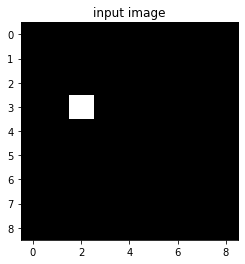

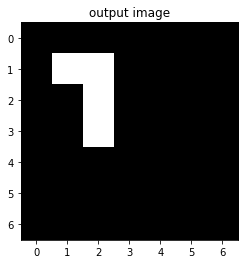

In [0]:
%matplotlib inline

img1 = np.array([[0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,1,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0]])

kernel1 = np.array([[1,0,0],
	                [1,0,0],
	                [1,1,0]])

plt.imshow(img1, cmap="Greys_r")
plt.title("input image")
plt.show()

plt.imshow(conv2d(img1, kernel1), cmap="Greys_r")
plt.title("output image")
plt.show()


```
Your answer: It activates multiple pixels thereby enlarging the single-pixel image.
```

__Apply the following 3x3 kernel to an image containing a step change in brightness. What is the effect of this kernel? Explain your finding in words.__

$$ kernel = \left(\begin{matrix}
          -1 & -1 & -1\\
          -1 & 8 & -1\\
          -1 & -1 & -1
       \end{matrix} \right)$$

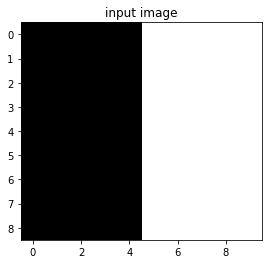

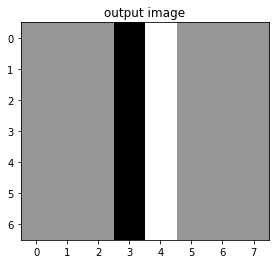

In [0]:
img2 =np.array([[0,0,0,0,0,1,1,1,1,1],
                [0,0,0,0,0,1,1,1,1,1],
                [0,0,0,0,0,1,1,1,1,1],
                [0,0,0,0,0,1,1,1,1,1],
                [0,0,0,0,0,1,1,1,1,1],
                [0,0,0,0,0,1,1,1,1,1],
                [0,0,0,0,0,1,1,1,1,1],
                [0,0,0,0,0,1,1,1,1,1],
                [0,0,0,0,0,1,1,1,1,1]])

kernel2 = np.array([[-1,-1,-1],
	                  [-1, 8,-1],
	                  [-1,-1,-1]])

plt.imshow(img2, cmap="Greys_r")
plt.title("input image")
plt.show()

plt.imshow(conv2d(img2, kernel2), cmap="Greys_r")
plt.title("output image")
plt.show()


```
Your answer: It acts as an edge detector here as it detects regions with a change in brightness
```

### Exercise 2. Apply convolution with different kinds of padding

Do you notice the size of the output image is different from the input size in the previous examples? Why does that happen?

```
Your answer: There is a decrease in output size due to convolution operation being performed on the input matrix as padding has been set to zero. The size of output matrix is the no of different places in the input matrix the kernel would fit into.
```

The 2d convolution operators illustrated in excercise 1 are called "valid" convolution. PyTorch use this padding scheme by default. There are three different kinds of padding "valid", "same", "full", which give you different output sizes. Scipy's documentary gives a good description of the three types: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.convolve.html

Now let's run the following code for "padding same" and "padding full" convolution using PyTorch's `conv` function. What are the output sizes? What do you find on border pixel and interior pixels? 

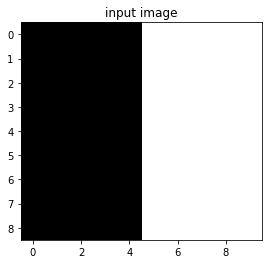

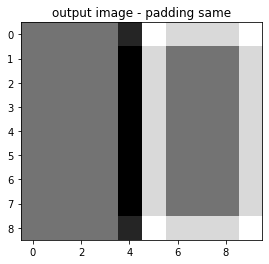

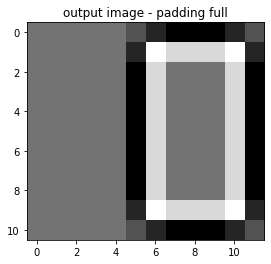

In [0]:
 """
     conv2d(input, kernel, padding) → numpy.array
     
  * paddding - implicit paddings on both sides of the input. can be a single number or a tuple (pad_height, pad_width)

"""

plt.imshow(img2, cmap="Greys_r")
plt.title("input image")
plt.show()

plt.imshow(conv2d(img2, kernel2, 1), cmap="Greys_r")
plt.title("output image - padding same")
plt.show()

plt.imshow(conv2d(img2, kernel2, 2), cmap="Greys_r")
plt.title("output image - padding full")
plt.show()

```
Your answer: The padded regions i.e the borders are set to 0 by default.
```

In general, if the kernel size is $n\times m$, what is the `padding` parameter for "padding full"? What is the `padding` parameter for "padding same"

```
Your answer: The "padding full" parameter for given kernel is (n-1,m-1) and the "padding same" parameter is ((n-1)/2,(m-1)/2)
```

### Exercise 3. Iterating over feature maps (channels) and batches. 

Making use of our 2D convolution `conv2d`, implement a convolution of all feature maps in a batch. This resembles a full convolutional layer (without biases). Before you start, take a close look at what each dimension means and what shape the output will be.

In [0]:
# [minibatch, in_channels, image_height, image_width]
img = np.random.rand(10, 5, 21, 19) 

# [out_channels, in_channels, kernel_height, kernel_width]
kernel = np.random.rand(3, 5, 5, 7)

desired = functional.conv2d(torch.tensor(img), torch.tensor(kernel)).numpy().squeeze()

# [minibatch, out_channels, image_height, image_width]
desired.shape


(10, 3, 17, 13)

__Fill in the missing parts (??) of the following code:__

In [0]:
"""
`conv2d_stack` - 2D "valid" convolution looping over minibatches and channels

    r = conv2d(input, kernel) → numpy.array

  * input  - input images of shape (minibach, in_channels, image_height, image_width)
  * kernel - kernels of shape (out_channels, in_channels, kernel_height, kernel_width)

  * r - output images of shape (minibach, out_channels, out_image_height, out_image_width)
"""

########## fill in the missing parts (??) of the following code ############
    
def conv2d_stack(im, kr):
    batchsize, n_feature_in, ih, iw = im.shape
    n_feature_out, _, kh, kw = kr.shape
    
    r = np.zeros((batchsize,n_feature_out,ih-kh+1,iw-kw+1))
    print(r[0,0])
    
    for i in range(batchsize):
        for j in range(n_feature_out):
            for k in range(n_feature_in):
                r[i,j] += conv2d(im[i,k], kr[j,k])

    return r

##############################################################################

The output of the following should be true, if your code is correct.

In [0]:
np.isclose(conv2d_stack(img, kernel), desired).all()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


True

PyTorch's conv2d takes care of all of this. While you will probably never write out all these for loops again, appreciate what torch (or any other library) is doing in the background in a fraction of the time. Run this timing example to see the speedup yourself:

In [0]:
# [batch, feature map, x, y]
img = np.random.rand(40, 20, 21, 21) 

# [feature map out, feature map in, x, y]
kernel = np.random.rand(10, 20, 5, 5)

%time desired = functional.conv2d(torch.tensor(img), torch.tensor(kernel)).numpy().squeeze()
%time r = conv2d_stack(img, kernel)

CPU times: user 7.28 ms, sys: 30.1 ms, total: 37.3 ms
Wall time: 37.4 ms
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
CPU time

When you implement your own neural network architectures, you can use PyTorch's convolutional layer `nn.Conv2d()` which encapsulate the `nn.functional.conv2d()` function. You will encounter this in the [LeNet](https://colab.research.google.com/drive/1Neif4TvzrHj9NUEaoZS2Y24HX5tVZFxo) notebook.